# Description
Trying new techniques using scipy and numpy to try and draw topographic lines given point based data.

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy
from scipy import ndimage

from matplotlib.colors import LogNorm

from scipy import interpolate

In [2]:
def get_hgt_data(filename):
    size = os.path.getsize(filename)
    dim = int(math.sqrt(size/2))

    assert dim*dim*2 == size, 'Invalid file size'

    data = np.fromfile(filename, np.dtype('>i2'), dim*dim).reshape((dim, dim),order='F')
    data = data.T
    data = np.flip(data,0)
    return data

In [3]:
filename = "../../hgt_data/n35e138.hgt"
print(filename)
data = get_hgt_data(filename)

../../hgt_data/n35e138.hgt


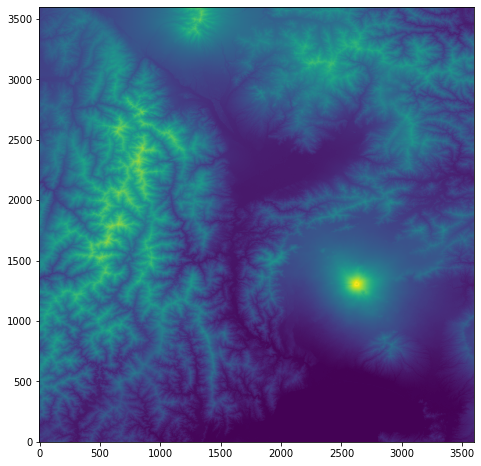

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(data,origin='lower')
plt.show()

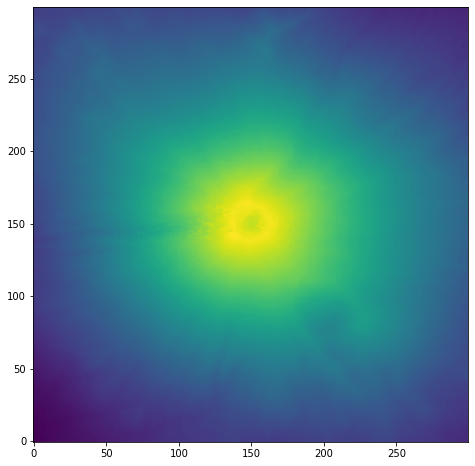

In [5]:
sliced_data = data[1156:1456, 2480:2780]
plt.figure(figsize=(8,8))
plt.imshow(sliced_data,origin='lower')
plt.show()

In [30]:
offset = 2500
delta_h = 100
bool_map = np.logical_and(offset < sliced_data, sliced_data < offset+delta_h)

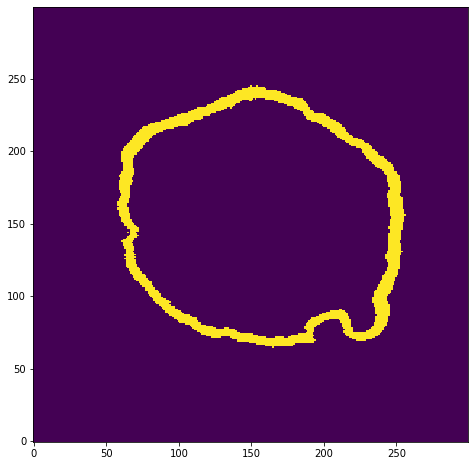

In [31]:
plt.figure(figsize=(8,8))
plt.imshow(bool_map,origin='lower')
plt.show()

In [32]:
#radians
def restrict_angle(angle):
    while angle > 2*np.pi:
        angle -= 2*np.pi
    while angle < 0:
        angle += 2*np.pi
    return angle

Last ditch resort: use a "snail" to inch around the plots and draw a line through it. Doesn't work well for all situations, especially peaks.

In [33]:
class Snail():
    def __init__(self,init_pos,init_dir,arc_rad,arc_width):
        self.pos = init_pos
        self.dir = init_dir
        self.arc_rad = arc_rad
        self.arc_width = arc_width
        self.nodes = []
        self.current_within_arc = None
    
    def addPatch(self,ax):
        wedge = patches.Wedge(self.pos,
                              self.arc_rad,
                              np.rad2deg(self.dir-self.arc_width/2.0),
                              np.rad2deg(self.dir+self.arc_width/2.0),
                              alpha=0.5,
                              color='red')
        
        circle = patches.Circle(self.pos,
                               1,
                               color='red')
        ax.add_artist(wedge)
        ax.add_artist(circle)
    
    def isWithinArc(self,point):
        i,j = point
        r = np.sqrt((j-self.pos[1])*(j-self.pos[1]) + (i-self.pos[0])*(i-self.pos[0]))
        theta = np.arctan2(j-self.pos[1],i-self.pos[0])
        theta = restrict_angle(theta)
        
        sub_bound = self.dir-self.arc_width/2.0
        sub_bound = restrict_angle(sub_bound)

        add_bound = self.dir+self.arc_width/2.0
        add_bound = restrict_angle(add_bound)
        
        if r < self.arc_rad:
            if  sub_bound < add_bound:
                if sub_bound < theta < add_bound:
                    return True
            else:
                if sub_bound < theta <= 2*np.pi or 0 <= theta < add_bound:
                    return True
                        
    def getPointsWithinArc(self,bool_map):
        points=[]
        new_map = np.zeros((bool_map.shape),dtype=bool)
        for j,row in enumerate(bool_map):
            for i,el in enumerate(row):
                if self.isWithinArc((i,j)) and bool_map[j,i]:
                    new_map[j,i] = True

        return new_map
    
    def getCentroid(self,bool_map):
        x_cent=0
        y_cent=0
        indices = np.argwhere(bool_map)
        for ind in indices:
            x_cent += ind[1]
            y_cent += ind[0]
        x_cent/=len(indices)
        y_cent/=len(indices)
        return x_cent,y_cent
    
    def advance(self,bool_map):
        #within_arc = self.getPointsWithinArc(bool_map)
        within_arc = self.getPointsWithinBoxArc(bool_map)
        self.current_within_arc = within_arc

        centroid = self.getCentroid(within_arc)
        new_dir = np.arctan2((centroid[1]-self.pos[1]),(centroid[0]-self.pos[0]))
        new_dir = restrict_angle(new_dir)
            
        self.nodes.append(self.pos)
        self.pos = centroid
        self.dir = new_dir
        
        for el in self.nodes:
            if self.isWithinArc(el):
                self.nodes.append(self.nodes[0]) # stick the first point back on the end
                return False
            
        return True
    
    def getSubBoxIndicies(self):
        y_lower = int(self.pos[1]-self.arc_rad)+1
        y_upper = int(self.pos[1]+self.arc_rad)+1
        x_lower = int(self.pos[0]-self.arc_rad)+1
        x_upper = int(self.pos[0]+self.arc_rad)+1
        
        return (x_lower,x_upper),(y_lower,y_upper)
    
    def getSubBox(self,bool_map):
        # add an extra pixel as padding
        x_lims,y_lims = snail.getSubBoxIndicies()
        x_lower,x_upper = x_lims
        y_lower,y_upper = y_lims
        
        return bool_map[y_lower:y_upper,x_lower:x_upper],x_lower,y_lower
    
    def getPointsWithinBoxArc(self,bool_map):
        points=[]
        new_map = np.zeros((bool_map.shape),dtype=bool)
        sub_box,x_lower,y_lower = self.getSubBox(bool_map)
        for j,row in enumerate(sub_box):
            for i,el in enumerate(row):
                if self.isWithinArc((i+x_lower,j+y_lower)) and sub_box[j,i]:
                    new_map[j+y_lower,i+x_lower] = True

        return new_map
        
    
    def printCurrentState(self):
        print("({:.2f} , {:.2f}) {:.2f}".format(self.pos[0],self.pos[1],np.rad2deg(self.dir)))

In [95]:
arc_rad = 10
arc_width = np.pi
snail = Snail((65 , 150),np.deg2rad(180),arc_rad,arc_width)
snail.printCurrentState()
x_lims,y_lims = snail.getSubBoxIndicies()

(65.00 , 150.00) 180.00


In [96]:
def snailPlot(snail):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(bool_map,origin='lower')
    snail.addPatch(ax)
    snail.printCurrentState()
    ax.set_xlim(75+15,225-10)
    ax.set_ylim(75+15,225-10)
    plt.show()

In [97]:
n_iter = 100
while snail.advance(bool_map):
    print(snail.nodes[-1])    

(65, 150)
(62.24444444444445, 154.8)
(61.65151515151515, 159.71212121212122)
(61.68571428571428, 164.42857142857142)
(62.5735294117647, 169.33823529411765)
(62.94736842105263, 174.57894736842104)
(63.172413793103445, 179.48275862068965)
(64.28571428571429, 184.16666666666666)
(65.15189873417721, 188.77215189873417)
(64.96052631578948, 193.85526315789474)
(65.67021276595744, 198.56382978723406)
(68.10752688172043, 202.5268817204301)
(71.37777777777778, 206.0888888888889)
(74.73333333333333, 209.53333333333333)
(78.25, 212.89772727272728)
(82.33333333333333, 215.56410256410257)
(86.88888888888889, 217.22222222222223)
(91.59154929577464, 218.6338028169014)
(96.38666666666667, 220.10666666666665)
(101.33333333333333, 221.44444444444446)
(105.8, 222.7125)
(110.39189189189189, 224.56756756756758)
(114.76388888888889, 226.40277777777777)
(119.3030303030303, 228.24242424242425)
(124.0, 230.0142857142857)
(128.6, 232.14666666666668)
(133.1818181818182, 233.84415584415584)
(137.67105263157896, 2

In [98]:
x, y = zip(*snail.nodes)
tck, u = interpolate.splprep([x, y], s=0, per=True)
xi, yi = interpolate.splev(np.linspace(0, 1, 1000), tck)

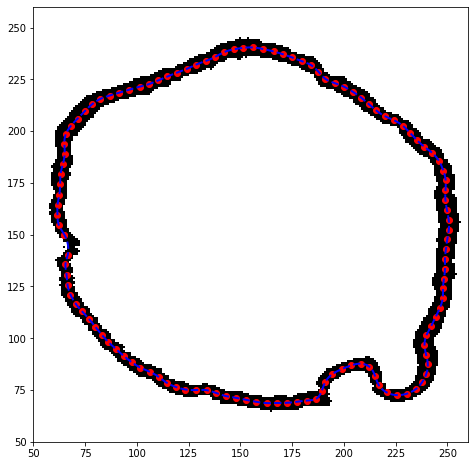

In [99]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(bool_map,origin='lower',cmap='gray_r')
ax.plot(x,y, linewidth=2,marker='o',color='red',linestyle='none')
ax.plot(xi,yi, linewidth=2,color='blue',linestyle='--')
ax.set_xlim(50,260)
ax.set_ylim(50,260)
plt.show()